# Tasks
## Understanding the problem
### Description
**Cliff Walking** is a *single-agent*, *deterministic*, and *discrete* reinforcement learning problem.
- Single agent means that there is only one agent. *aka not multi-agent*.
- Deterministic means that given an action-state pair `(s, a)`, the transition function will always yield state `s'`. *aka not stochastic*.
- Discrete means that there is a countable amount of actions and observations. *aka not continuous*.

The *goal of the agent* is to go from the starting position to the target position without falling off the cliff.

The *action space* is of shape (4,). The agent is equipped with 4 directional movements to navigate the environment.

The *observation space* is of shape (48,). An observation represents the position of the agent on the map. There are 37 allowed states, and ` states the agent must avoid.

The *reward* is: -1 for each step the agent takes, and -100 for falling off the cliff. No reward is necessary for reaching the goal as the target position represents the *terminal state*, meaning that for the agent to maximize its reward, it is implied that it must reach the target position.

### Optimal policy
The optimal policy to solve this problem would be to move right alongside the cliff and reach the finish point without going north, minimizing the travel cost.

### Highest/Lowest reward achievable
The **highest** reward achievable is -13, as the agent needs a minimum of 13 steps to reach the terminal state.

*For the pre-configured parameters of this assignment*, the **lowest** reward achievable is -1099, as the agent can travel for 999 steps, and on their final 1000th step they can walk off the cliff for -100 reward.

## Baseline strategy: Equiprobable Random Policy

In [145]:
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import random
import numpy as np
from typing_extensions import override

In [146]:
RENDER_MODE = "graphic"  # choose between "graphic" or text;  graphic mode needs the pygame package to be installed
RENDER_FREQUENCY = 0.2  # output the game state at most every X seconds

env = gym.make('CliffWalking-v0', render_mode = "rgb_array" if RENDER_MODE == "graphic" else "ansi") # initialize the game

In [147]:
# This is a dumb agent that applies a policy that makes it run in circles
#   you can use this example agent class as a temple for implementing smarter ones
# Feel free to add methods if you consider it necessary
class DumbAgent():
    def __init__(self):
        self.previous_action = -1 # This agent needs to remember which direction he was going before so he can make nice circles

    # decide what action to take in the provided state by applying a certain policy
    def select_action(self, state):
        new_action = (self.previous_action + 1) % 4 # this agents policy is to run in circles
        self.previous_action = new_action
        return new_action
    
    # do the learning (e.g. update the Q-values, or collect data to do off-policy learning)
    def update(self, old_state, action, reward, new_state):
        pass # this agent just does not learn anything \_o_/

    # reset the agent to its initial state after an epoch. Can also be used to perform learning after an epoch)
    def reset(self, state):
        self.previous_action = -1

def to_coord(state_id):
    # we return the (x, y) coorinates, in the description page the use [y, x] to describe the locations
    return (state_id % 12, state_id // 12)

actions = {
    0: "up",
    1: "right",
    2: "down",
    3: "left"
}

In [148]:
## Returns the number of steps taken and the ending reason (-1 if fallen off, 0 if survived but out of steps, 1 if reached goal)
def run_episode(agent, max_steps = 1000, muted = False):
    observation, info = env.reset() # restart the game
    agent.reset()

    for k in range(max_steps):
        action = agent.select_action(observation)  # select an action based on the current state
        new_observation, reward, terminated, truncated, info = env.step(action)  # perform the action and observe what happens 
        fallen_off_cliff = (reward == -100)  # Beware! we cannot check for cliff state because the environment automatically returns us to the starting position when falling off a cliff
        goal_reached = terminated  # if we reach the goal state, the environment returns terminated = True 

        agent.update(observation, action, reward, new_observation)  # perform some learning if the agent is capable of it
        agent.total_reward += reward

        if goal_reached:
            return k+1, 1, agent.total_reward  # we reached the goal
        elif fallen_off_cliff:
            
            return k+1, -1, agent.total_reward # we fell off the cliff

        observation = new_observation

    return k+1, 0, agent.total_reward  # we survived but did not reach the goal

In [149]:
def run_experiment(agent, episodes = 500):
    win_count = 0
    rewards = []
    mute_output = False # you may want to mute the output if you run a lot of episodes

    for _ in range(episodes):
        steps, reason, reward = run_episode(agent, muted=mute_output)
        rewards.append(reward)
        if reason == 1:
            win_count += 1
    print(f"Reached goal {win_count} times out of {episodes} games.")
    return win_count, rewards

### Implement a new ERP Agent

In [150]:
class ERPAgent(DumbAgent):
    """Agent with Equiprobable Random Policy
    """
    @override
    def __init__(self):
        self.total_reward = 0
        
    @override
    def select_action(self, obs):
        """Returns random action."""
        new_action = env.action_space.sample()
        return new_action
        
    @override
    def reset(self):
        self.total_reward = 0

In [151]:
def plot_agent_perf(rewards, episodes=500):
    plt.scatter(x=range(episodes), y=rewards, label='reward')
    plt.xlabel('episodes')
    plt.ylabel('reward')
    plt.legend()
    plt.show()

### Evaluate ERP Agent
The random policy is not effective. The agent **very rarely reaches the goal once in 500 episodes**. Average reward across 500 episodes is printed below. Optimal reward is never reached.

Reached goal 3 times out of 500 games.


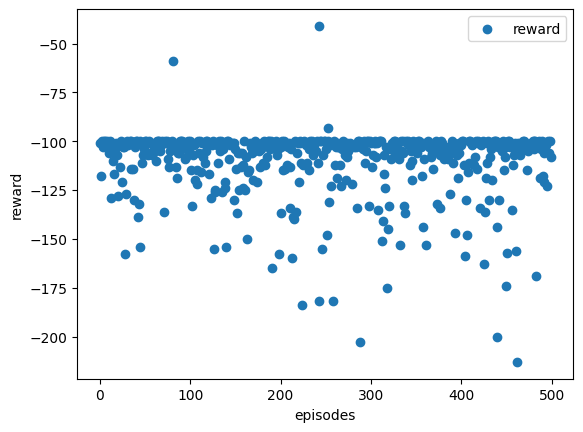

average reward -110.244


In [152]:
agent = ERPAgent()
wins, rewards = run_experiment(agent)
plot_agent_perf(rewards)
print("average reward", sum(rewards)/len(rewards))
env.close() # end the game

## Q-Learning


## Improving Q-Learning